In [4]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
import imodelsx.util
import sasc.viz
import pickle as pkl
from PIL import Image
import img2pdf
import json
from copy import deepcopy
from numpy.linalg import norm
from math import ceil
from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR
import sasc.modules.fmri_module
ngrams_list = joblib.load(join(cache_ngrams_dir, 'fmri_UTS02_ngrams.pkl')) # ngrams are same for both models

subject = 'S02'
# subject = 'S03'
# rois_dict = joblib.load(join(regions_idxs_dir, f'rois_{subject}.jbl'))
rois = joblib.load(join(FMRI_DIR, 'brain_tune/voxel_neighbors_and_pcs/', 'communication_rois_UTS02.jbl'))
rois_dict_raw = {i: rois[i] for i in range(len(rois))}

# custom merge contralateral regions
raw_idxs = [
    [0],
    [1, 5],
    [2, 6],
    [3, 4],
]
rois_dict = {
    i: np.vstack([rois_dict_raw[j] for j in idxs]).sum(axis=0)
    for i, idxs in enumerate(raw_idxs)
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualize ROIs

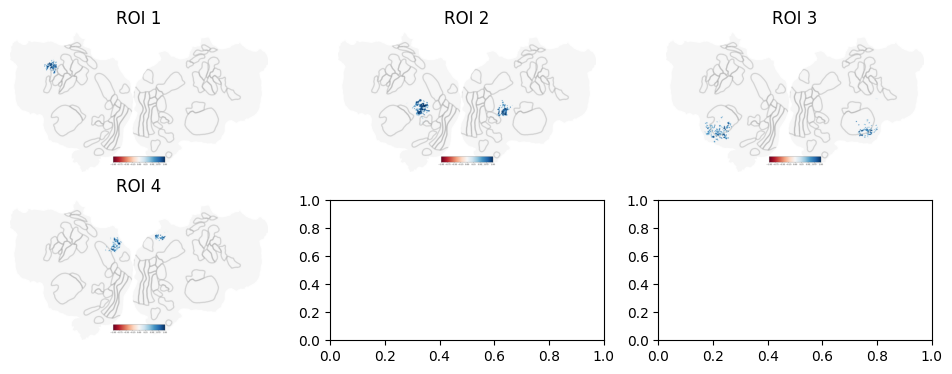

In [10]:
# # save pcs
n_rois = len(rois_dict)
for i in range(n_rois):
    flatmap = rois_dict[i]
    # flatmap = np.zeros(weights_arr_full.shape[1])
    # flatmap[pfc] = pc_coefs_per_voxel[:, pc_num]
    sasc.viz._save_flatmap(
        flatmap, 'S02', fname_save=f'rois_custom_images/communication_{i}.png')

# read all plots and save as subplots on the same page
C = 3
R = ceil(n_rois/C)
fig, axs = plt.subplots(R, C, figsize=(C * 4, R * 2))
axs = axs.ravel()
for i in range(n_rois):
    axs[i].imshow(Image.open(f'rois_custom_images/communication_{i}.png'))
    axs[i].axis('off')
    axs[i].set_title(f'ROI {i + 1}')
plt.savefig('communication_subplots.png')

### Get predictions from embs

In [ ]:
for embs_fname, checkpoint, out_suffix in tqdm(zip(
    ['fmri_embs.pkl', 'fmri_embs_llama.pkl'],
    ['facebook/opt-30b', 'huggyllama/llama-30b'],
    ['_opt', '_llama'],
)):
    print(f'Running for {embs_fname}')
    embs = joblib.load(join(cache_ngrams_dir, embs_fname))
    # embs = joblib.load(join(cache_ngrams_dir, 'fmri_embs_llama.pkl'))
    mod = sasc.modules.fmri_module.fMRIModule(
        subject=f"UT{subject}",
        checkpoint=checkpoint,
        init_model=False,
        restrict_weights=False,
    )
    voxel_preds = mod(embs=embs, return_all=True)

    print('Saving outputs for clusters')
    outputs_dict = {
        k: voxel_preds[:, np.array(rois_dict[k])].mean(axis=1)
        for k in rois_dict
    }

    joblib.dump(outputs_dict, join(
        cache_ngrams_dir, f'rois_communication_ngram_outputs_dict_{subject}{out_suffix}.pkl'))

0it [00:00, ?it/s]

Running for fmri_embs.pkl
initializing fmri...


### Load outputs

In [ ]:
outputs_dict = joblib.load(
    join(cache_ngrams_dir, f'rois_ngram_outputs_dict_{subject}_opt.pkl'))
df_opt = pd.DataFrame(outputs_dict, index=ngrams_list)
outputs_dict = joblib.load(
    join(cache_ngrams_dir, f'rois_ngram_outputs_dict_{subject}_llama.pkl'))
df_llama = pd.DataFrame(outputs_dict, index=ngrams_list)
df = df_opt + df_llama
# ROIS_LOC = ['RSC', 'PPA', 'OPA']  # 'OPA', 'PPA']
ROI_NAMES = rois_dict.keys()
for k in ROI_NAMES:
    df_opt[str(k) + '_only'] = df_opt[k] - \
        df_opt[[c for c in ROI_NAMES if c != k]].mean(axis=1)
    df_llama[str(k) + '_only'] = df_llama[k] - \
        df_llama[[c for c in ROI_NAMES if c != k]].mean(axis=1)
    df[str(k) + '_only'] = df[k] - \
        df[[c for c in ROI_NAMES if c != k]].mean(axis=1)

In [ ]:
stability_scores = {
    k: np.corrcoef(df_opt[k], df_llama[k])[0, 1]
    for k in df.columns
}

In [ ]:
ascending = False  # should be false to get driving ngrams
top_ngrams_dict = {}
for k in df.columns:
    top_ngrams_dict[k] = df.sort_values(
        k, ascending=ascending).index[:100].tolist()
    # if k in ROIS_LOC:

    # top_ngrams_dict[k + '_only'] = df.sort_values(
    # k + '_only', ascending=ascending).index[:100].tolist()
top_ngrams_df = pd.DataFrame(top_ngrams_dict)
top_ngrams_df.to_csv(f'top_ngrams_by_roi_{subject}.csv')
with pd.option_context('display.max_rows', None):
    rois = rois_dict.keys()
    # rois = [r for r in rois if not r == 'pSTS']  # never localized pSTS in S03
    display(top_ngrams_df[rois])
top_ngrams_df.to_pickle(
    f'top_ngrams_custom_communication_{subject}.pkl')

In [ ]:
gpt4 = imodelsx.llm.get_llm('gpt-4-turbo-0125-spot')
try:
    explanations = json.load(open(f'explanations_by_roi_{subject}.json', 'r'))
except:
    explanations = {}
for k in top_ngrams_df.columns:

    s = '- ' + '\n- '.join(top_ngrams_df[k].iloc[:60])
    prompt = f'''Here is a list of phrases:
    {s}

    What is a common theme among these phrases? Return only a concise phrase.'''
    if not k in explanations:
        explanations[k] = gpt4(prompt)
json.dump(explanations, open(
    f'explanations_by_roi_{subject}.json', 'w'), indent=4)

In [ ]:
{k: explanations[k] for k in rois}

In [22]:
print(top_ngrams_df['PPA_only'].values.tolist())

['my trapper keeper', 'a garbage bag', 'placemats some crayons', 'on paper plates', 'that garbage bag', "'re throwing napkins", 'box of discarded', 'your worry beads', 'of wrapping paper', 'a fire hose', 'a business card', 'of sweatpants', "'d grown napkins", 'wrapped my napkin', 'in sugar jars', 'two room school', 'their chew toys', 'his flannel shirt', 'grabbed the trashbag', 'garbage bag', 'those plastic containers', 'his bathrobe', 'their cigarette wrappers', 'an overturned cardboard', 'socks and loafers', 'that beach towel', 'the air mattress', 'my bathrobe', 'our dishwasher', 'a bathrobe', 'the cough syrup', 'a stuffed animal', 'skivvies toothbrush floss', 'an air mattress', 'powerlifting cinder blocks', 'glasses of cheap', 'chew toys', 'of cheap beer', 'bath in bathrobes', 'a hospital bed', 'the tiny crumpled', 'throwing napkins', 'the laundry hamper', 'overturned cardboard box', 'like your shirt', 'wearing sweatpants', 'a trash can', 'milk bottle tops', 'was wearing sweatpants'

### S03 Export selected rois to pkl

In [24]:
rois = ['RSC', 'OPA', 'PPA', 'IPS', 'sPMv', 'EBA', 'OFA'] + \
    ['RSC_only', 'OPA_only', 'PPA_only']  # all but 'pSTS'
# pprint({k: explanations[k] for k in rois})
explanations_clean = {
    'EBA': 'Body parts',
    'IPS': 'Descriptive elements of scenes or objects',
    # OFA differs from UTS02 (which was "'Personal growth and reflection',")
    'OFA': 'Conversational transitions',
    'OPA': 'Direction and location descriptions',
    # OPA_only differs from UTS02 (which was 'Spatial positioning and directions')
    'OPA_only': 'Self-reflection and growth',
    'PPA': 'Scenes and settings',
    'PPA_only': 'Unappetizing foods',
    'RSC': 'Travel and location names',
    'RSC_only': 'Location names',
    # sPMv differs from UTS02 (which was 'Time and Numbers')
    'sPMv': 'Dialogue and responses',
}
explanation_avoid_suffixes = {
    'EBA': ' Avoid mentioning any locations.',
    'IPS': ' Avoid mentioning any locations.',
    'OFA': ' Avoid mentioning any locations.',
    'OPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'OPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'RSC': '',
    'RSC_only': '',
    'sPMv': ' Avoid mentioning any locations.'
}
for roi in rois:
    print(f'"{roi}":', str(
        top_ngrams_df[roi.replace('1', '').replace('2', '')].iloc[:50].values.tolist()) + ', ')
top_ngrams_clean = {
    "RSC": ['was led upstairs', 'onto the subway', 'to the hallway', 'drove to washington', 'back through london', 'and darted downstairs', 'past the offices', 'long hallway toward', 'down the sidewalk', 'back in manhattan', 'reached the interstate', 'just blocks away', 'drove from vermont', 'was standing outside', 'to a courtyard', 'in the alley', 'up the coast', 'from my dorm', 'in the courtyard', 'in central park', 'i walk outside', 'here in manhattan', 'darted downstairs', 'facing the beach', 'walk through downtown', 'wander the hallways', 'i ran downstairs', 'down the hall', "'m standing outside", 'off into vancouver', 'through the streets', 'sitting in indianapolis', 'on sixth avenue', 'i go upstairs', 'across the street', 'arrived in indianapolis', 'we were downtown'],
    "OPA": ['railing looking out', 'across a plateau', 'up the coast', 'against the railing', 'in the courtyard', 'up the hill', 'above the gulf', 'outside the windows', 'long hallway toward', 'over the gulf', 'past the offices', 'through the windows', 'beside the river', 'past the waterfall', 'across the bridge', 'this long hallway', 'to a courtyard', 'and the courtyard', 'and behind me', 'down this embankment', 'towards the river', 'the hill up', 'courtyard was surrounded', 'in an alcove', 'onto the railing', 'along the coast', 'up the stairs', 'across the quadrangle', 'facing the beach', 'to the north', 'down the corridor', 'through the gates', 'over the embankment', 'onto the bridge', 'down that corridor', 'down the sidewalk', 'i looked across', 'path that jutted', 'through this door', 'the lagoon behind', 'down the embankment', 'on the railing', 'on the embankment', 'through the doors', 'on the windowsill', 'corridor out onto', 'the buildings beside', 'to the hallway', 'by that window', 'past the city', 'door behind me', 'to the south', 'off the coast', 'cross the bering', 'around the reef', 'behind me i', 'driveway and behind', 'against the windows', 'across the street', 'to the shoreline', 'lagoon behind the', 'on the sidewalk', 'hall past the', 'off the east', 'of the ravine', 'surrounded the city', 'in the window', 'southern shore of', 'in the distance', 'onto the sidewalk', 'i look across', 'behind us i', 'behind us there', 'on the cliff', 'over the river', 'toward the ocean', 'on that terrace', 'row of stalls', 'sidewalk in front', 'down the long', 'on the walls', 'door to the', 'by the window', 'outside my door', 'outside the door', 'across from me', 'on the eastern', 'the hall past', 'down the lagoon', 'in the forest', 'that window in', 'around me the', 'to the barrier', 'the gulf where', 'road in front', 'in the hallway', 'across the parking', 'in the colonnade', 'to the western', 'surrounded by rooms'],
    "PPA": ['in an alcove', 'on the stoop', 'past the offices', 'against the railing', 'on the windowsill', 'in the alley', 'to a courtyard', 'the copier room', 'in the courtyard', 'this long hallway', 'to the hallway', 'on a dock', 'in the hallway', 'long hallway toward', 'outside the windows', 'on that terrace', 'inside the hut', 'railing looking out', 'through the windows', 'down this embankment', 'on the subway', 'onto the subway', 'there were shelves', 'in my cubicle', 'a strip mall', 'on the sidewalk', 'in the colonnade', 'on the railing', 'into the basement', 'across the parking', 'a restaurant stoop', 'onto the railing', 'exit the subway', 'by the window', 'in that attic', 'was led upstairs', 'in the basement', 'the food court', 'and the courtyard', 'in the cafeteria', 'hall past the', 'into the parking', 'in the windowless', 'back room where', 'on my bed', 'down the sidewalk', 'contain strip malls', 'onto the sidewalk', 'the hall closet', 'at those cliffs'],

    "RSC_only": ['moved to chicago', 'drove from vermont', 'came to florida', 'here in manhattan', 'living in chicago',  'move to texas', 'leaving for france', 'back in manhattan', 'to boston to', 'went to boston', 'moved to vermont', 'geese in ohio', 'college in boston', 'in ohio', 'moved to brooklyn', 'normal suburban pittsburgh', 'moved to london', 'back in israel', 'to london to', 'come from israel', 'went to manchester', 'to columbus ohio', 'here in boston', 'i left vermont', 'from pittsburgh pennsylvania', 'in lower manhattan', 'hometown in texas', 'touring through europe', 'in warmer mexico', 'union in manhattan', 'suburban pittsburgh', 'moved to washington', 'was in boston', 'slacking in madison', 'chick from silverlake', 'heading to iraq', 'in chicago', 'in louisville kentucky', 'lived in hiroshima', 'in florida'],
    "OPA_only": ['eventually i forgave', 'push past it', 'eventually forgave', 'she eventually forgave', 'i forgave', 'to see ourselves', 'of myself which', 'means extending empathy', 'forgive and', 'i stopped myself', 'forgive and love', 'of the hurt', 'i rise above', 'i pushed myself', 'is and who', "'m hurt but", 'see ourselves and', 'the hurt', 'i persisted and', 'to forgive afterwards', 'was real to', 'comparing myself', 'looked in myself', 'selves which', 'around it and', 'self which translated', 'inside me that', 'of me which', 'overcome my ambivalence', 'to push myself', 'was also influenced', 'the side which', 'side which', 'independence and freedom'],
    "PPA_only": ['a garbage bag', 'that garbage bag', "'re throwing napkins", 'box of discarded', 'in sugar jars', 'their chew toys', 'those plastic containers', 'our dishwasher', 'skivvies toothbrush floss', 'of cheap beer', 'throwing napkins', 'a trash can', 'milk bottle tops', 'want a mcflurry', 'vomit smelling couch', 'grown napkins', 'my cheese sandwich', 'overpriced coffee shops', 'some lighter fluid', 'salad and stale', 'vomited a washpan', 'these brown paper'],

    "IPS": ['and behind me', 'against the railing', 'onto the railing', 'path that jutted', 'situated herself behind', 'above the gulf', 'door behind me', 'southern shore of', 'i looked across', 'along the edge', 'closed behind me', 'behind me and', 'across a plateau', 'on the railing', 'up behind me', 'leaning against the', 'towering above me', 'jutted into the', 'onto the bridge', 'and cut across', 'behind him and', 'and came around', 'front of us', 'up onto the', 'over the gulf', 'stood behind me', 'across the bridge', 'beside the river'],
    "sPMv": ['repeated her affirmation', 'said excuse me', 'asked i laughed', 'and goes hey', 'response was nah', 'hurry she exclaimed', 'said no i', 'just nodded yes', 'retorted rather loudly', 'was like hey', 'called her and', 'and said yes', 'and screams fuck', 'said uh hey', 'says sure and', 'says uh actually', 'was like hi', 'i said fine', 'said without hesitation', 'said well yes', 'says excuse me', 'i asked immediately', 'she yelled i', 'said mom mom', 'said did i', 'i said wow', 'i said shyly', 'asked her and', 'said okay okay', 'i sheepishly raise', 'which i responded', 'turned and said', 'then wrote yes', 'said yes i', 'whisper she said', 'was like mhm'],
    "EBA": ['arms around her', 'wraps his arms', 'hands gripped the', 'into my palm', 'hands into my', 'elbows on knees', 'grab his arms', 'his hands folded', 'into her arms', 'grabbed her hand', 'arms flailing', 'grabbed her legs', 'arm around my', 'grabbed their hands', 'lifted her up', 'put my arms', 'leaned his head', 'put his arms', 'shakes my hand', 'flying arms flailing', 'i leaned down', 'arms tighten around', 'her hands gripped', 'hand on his', 'my feet kicking', 'pinning my arms', 'held her hand', 'in a headlock', 'pressed my face', 'holds her hand', 'arms flailing holding', 'rubbing his head'],
    "OFA": ['and we talked', 'i even met', 'and so finally', 'one night my', 'one evening after', 'anyway the point', 'one summer my', 'weeks passed and', 'finally one day', 'then we talked', 'one night i', 'we chatted', 'and i talked', 'we talked and', 'talked and', 'so i texted', 'to my surprise', 'one afternoon when', 'i persisted and', 'and i finally', 'was watching television', 'i remember once', 'so one night', 'but anyway', 'and i met', 'when i finally', 'so i finally', 'on and on', 'son had finally', 'and i especially', 'so one day', 'and eventually i', 'we brace ourselves', 'so anyway', 'i was perusing', 'and it finally', 'later that day', 'so we finally', 'but anyhow', 'and as we', 'the day came', 'home one afternoon', 'then i finally', 'what fascinated me', 'and i vaguely', 'so i talked', 'once while i', 'was hanging out', 'i was reliving', 'but the most'],
}

rows = {
    'roi': rois,
    'expl': [explanations_clean[k] for k in rois],
    'top_ngrams_module_correct': [top_ngrams_clean[k] for k in rois],
    'stability_score': [stability_scores[k.split('_')[0]] for k in rois],
    'subject': [f'UT{subject}'] * len(rois),
    'voxel_nums': [rois_dict[k.split('_')[0]] for k in rois],
    'prompt_suffix': [explanation_avoid_suffixes[k] for k in rois],
}
rows = pd.DataFrame(rows)
rows.to_pickle(f'rows_roi_ut{subject.lower()}_may31.pkl')

"RSC": ['was led upstairs', 'onto the subway', 'to the hallway', 'in the hallway', 'we ran upstairs', 'drove to washington', 'exit the subway', 'back through london', 'on the subway', 'and darted downstairs', 'past the offices', 'long hallway toward', 'down the sidewalk', 'back in manhattan', 'we go downstairs', 'reached the interstate', 'onto the sidewalk', 'this long hallway', 'just blocks away', 'up the stairs', 'to my dorm', 'in lower manhattan', 'on the sidewalk', 'down the corridor', 'took the subway', 'drove from vermont', 'was standing outside', 'to a courtyard', 'in the alley', 'up the coast', 'from my dorm', 'in the courtyard', 'in central park', 'i walk outside', 'here in manhattan', 'darted downstairs', 'facing the beach', 'walk through downtown', 'wander the hallways', 'i ran downstairs', 'down the hall', "'m standing outside", 'off into vancouver', 'through the streets', 'sitting in indianapolis', 'on sixth avenue', 'i go upstairs', 'across the street', 'arrived in indian

### S02 Export selected rois to pkl

In [ ]:
rois = ['RSC', 'OPA', 'PPA', 'IPS', 'pSTS', 'sPMv',
        'EBA', 'OFA'] + ['RSC_only', 'OPA_only', 'PPA_only2']  # 'PPA_only1',
# pprint({k: explanations[k] for k in rois})
explanations_clean = {
    'EBA': 'Body parts',
    'IPS': 'Descriptive elements of scenes or objects',
    'OFA': 'Personal growth and reflection',
    'OPA': 'Direction and location descriptions',
    'OPA_only': 'Spatial positioning and directions',
    'PPA': 'Scenes and settings',
    'PPA_only': 'Unappetizing foods',
    'RSC': 'Travel and location names',
    'RSC_only': 'Location names',
    'pSTS': 'Verbal interactions',
    'sPMv': 'Time and numbers'}
explanation_avoid_suffixes = {
    'EBA': ' Avoid mentioning any locations.',
    'IPS': ' Avoid mentioning any locations.',
    'OFA': ' Avoid mentioning any locations.',
    'OPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'OPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'PPA_only': ' Avoid mentioning any specific location names (like "New York" or "Europe").',
    'RSC': '',
    'RSC_only': '',
    'pSTS': ' Avoid mentioning any locations.',
    'sPMv': ' Avoid mentioning any locations.'
}
for roi in rois:
    print(f'"{roi}":', str(
        top_ngrams_df[roi.replace('1', '').replace('2', '')].iloc[:50].values.tolist()) + ', ')
    # {
    # roi:  for roi in rois
# })
top_ngrams_clean = {
    "RSC": ['drove from vermont', 'to washington', 'in manhattan', 'here in boston', 'off into vancouver', 'moved to chicago', 'was in mexico', 'arrived in indianapolis', 'came to florida', 'i left vermont'],
    "OPA": ['onto the railing', 'towards the river', 'onto the sidewalk', 'towards the doors', 'outside the windows', 'long hallway toward', 'to the horizon', 'towards the street', 'over the gulf', 'to my left', 'path that jutted', 'on the ceiling', 'on the windowsill', 'down this embankment', 'up those stairs', 'above the gulf', 'facing the beach'],
    "PPA": ['mile of cornfields', 'the windowsill', 'the rolling hills', 'beautiful moonlit mountains', 'giant stone cliffs', 'a strip mall', 'nondescript office buildings', 'manicured lawns', 'lakes', 'the dark driveway', 'and shimmering skyscrapers', 'a private beach', 'the leafy garden', 'our modest backyard', 'my dorm'],

    "RSC_only": ['florida', 'israel', 'london', 'marrakesh', 'indianapolis', 'paris', 'pennsylvania', 'tokyo', 'tenessee', 'boston', 'vermont', 'chicago', 'indianapolis'],
    "OPA_only": ['towards the ceiling', 'onto the railing', 'feet hanging over', 'towards the doors', 'seats behind', 'towards the door', 'lights peeking over', 'to my left', 'situated herself behind', 'you sit backward', 'to the horizon', 'maybe twelve feet', 'at the ceiling', 'towards the street', 'of seats behind', 'twenty feet above', 'his back turned', 'see the horizon', 'seats behind the', 'to my right', 'and high rafters', 'about twenty feet', 'door behind me', 'the door behind', 'toward the back', 'over his shoulder', 'feet above the', 'hands went underneath', 'towards the ground', 'his feet hanging', 'feet touch the', 'behind her and', 'stand in front', 'down one side', 'on opposite sides', 'over the ceiling', 'on either side'],
    # "PPA_only": ['kind of corny', 'his painting sucked', 'snake oil', 'liar fake', 'fake name', 'bad puns', 'as an insult', 'called baloney'],
    "PPA_only2": ['like burnt steak', 'like pudding', 'tasted pretty bad', 'stale baked goods', 'the crusts', 'baloney', 'yeast extract', 'a sandwich rejected',],

    "IPS": ['there were slats', 'four connected squares', 'in long rows', 'on the sides', 'a long narrow', 'that forms horizontal', 'long rows of', 'sixty foot wide', 'between buttered slices', 'mile thick ice', 'all four corners', 'along the top'],
    "pSTS": ['said excuse me', 'says excuse me', 'room went silent', 'someone shouted', 'i provoked gasps', 'somebody then yelled', 'she started laughing', 'excuse me', 'asked i laughed', 'exhalation someone shouted', 'retorted rather loudly', 'turned and said', 'hurry she exclaimed', 'i started yelling', 'say excuse me', 'i started laughing', 'interrupted the conversation', 'breath he yelled', 'moment she gasped', 'said guess what'],
    "sPMv": ['one', 'forty', 'april nineteen forty', 'was sixteen seventeen', 'five only twenty', 'three down', 'march twentieth nineteen', 'more time passed', 'fifteen meters fifty', "turning ninety", 'june of nineteen'],
    "EBA": ['wraps his arms', 'lifted her dress', 'arms flailing', 'hands gripped the', 'grabbed her legs', 'his hands folded', 'my feet kicking', 'navigated pushy elbows', 'elbows on knees', 'over his shoulder'],
    "OFA": ['of my childhood', 'newfound self esteem', 'so my shrink', 'hurtful first dates', 'recall many instances', 'it felt magical', 'answered many questions', 'my school days', 'no satisfying fantasies', 'my mom often', 'from our childhood', 'growing up we', 'good friends often', 'shaped their mind', 'everything my parents'],
}

rows = {
    'roi': rois,
    'expl': [explanations_clean[k] for k in rois],
    'top_ngrams_module_correct': [top_ngrams_clean[k] for k in rois],
    'stability_score': [stability_scores[k.split('_')[0]] for k in rois],
    'subject': [f'UT{subject}'] * len(rois),
    'voxel_nums': [rois_dict[k.split('_')[0]] for k in rois],
    'prompt_suffix': [explanation_avoid_suffixes[k] for k in rois],
}
rows = pd.DataFrame(rows)
rows.to_pickle(f'rows_roi_ut{subject.lower()}_may31.pkl')